In [1]:
GSA.read.gmt = function(filename){
    # Read in and parse a gmt file (gene set file) from the  Broad institute
    # this is tricky, because each lines (geneset) has a variable length
    #  I read the file twice, first to pick up the geneset name and description
    # in the   first two  columns, then I read it all in as a long string

    # The beginning and end of each gene set in the string
    # is determined by matching
    # BOTH on  geneset name and description (since geneset names sometimes
    # occur as genenames elsewhere in the file)

    a = scan(filename,what = list("",""),sep = "\t", quote = NULL, fill = T, flush = T,multi.line = F)
    geneset.names = a[1][[1]]

    geneset.descriptions = a[2][[1]]

    dd = scan(filename,what = "",sep = "\t", quote = NULL)


    nn = length(geneset.names)
    n = length(dd)
    ox = rep(NA,nn)

    ii = 1
    for(i in 1:nn){
        while((dd[ii] != geneset.names[i]) | (dd[ii+1] != geneset.descriptions[i]) ){
            ii = ii+1
        }
        ox[i] = ii
        ii = ii+1
    }

    genesets = vector("list",nn)

    for(i in 1:(nn-1)){
        i1 = ox[i]+2
        i2 = ox[i+1]-1
        geneset.descriptions[i] = dd[ox[i]+1]
        genesets[[i]] = dd[i1:i2]
    }

    geneset.descriptions[nn] = dd[ox[nn]+1]
    genesets[[nn]] = dd[(ox[nn]+2):n]
    out = list(genesets = genesets,geneset.names = geneset.names, geneset.descriptions = geneset.descriptions)
    class(out) = "GSA.genesets"
    return(out)
}

In [2]:
library(tidyverse)
library(magrittr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [3]:
names <- GSA.read.gmt("../data/acsn/acsn_names.gmt")
names <- data_frame(acsnName = names$geneset.names,
                    genes = lapply(names$genesets, paste, collapse = ";")) %>%
    mutate(gene = strsplit(as.character(genes), ";")) %>% 
    unnest(gene)
acsn <- read_tsv("../data/acsn/acsn_ppi_ver2.txt", col_types = "cccc") %>%
    merge(names, by.x = "INTERACTOR1", by.y = "acsnName", all.x = T) %>%
    merge(names, by.x = "INTERACTOR2", by.y = "acsnName", all.x = T) %>%
    select(gene.x, gene.y, INTERACTION_TYPE)

K <- acsn %>%
    select(gene.x, gene.y) %>%
    apply(1, function(x){ paste(sort(x), collapse = "-")} )
acsn <- data_frame(key = K, type = acsn$INTERACTION_TYPE, acsn = TRUE) %>%
    mutate(type = strsplit(as.character(type), ";")) %>%
    unnest(type)

# biogrid
mitab <- "../data/genesis/BIOGRID-ORGANISM-Homo_sapiens-3.4.160.tab.txt"
K <- read_tsv(mitab, col_types = "cccccccciii") %>%
    select(OFFICIAL_SYMBOL_FOR_A, OFFICIAL_SYMBOL_FOR_B) %>%
    apply(1, function(x){ paste(sort(x), collapse = "-")} )
biogrid <- data_frame(key = K, biogrid = TRUE)

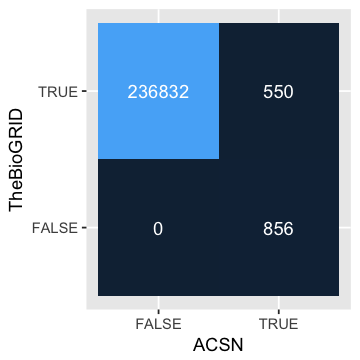

In [4]:
consensus <- merge(acsn, biogrid, all = TRUE) %>%
    mutate(biogrid = ifelse(is.na(biogrid), F, T),
           acsn = ifelse(is.na(acsn), F, T))

options(repr.plot.width=3, repr.plot.height=3)
consensus %>%
    filter(is.na(type) | type == "PROTEIN_INTERACTION") %>%
    select(key, acsn, biogrid) %>%
    unique %>%
    select(acsn, biogrid) %>%
    table %>%
    as.data.frame %>%
    ggplot(aes(x = acsn, y = biogrid)) +
        geom_tile(aes(fill = Freq)) +
        geom_text(aes(label = Freq), color = "white") + 
        labs(x = "ACSN", y = "TheBioGRID") +
        theme(legend.position = "none")

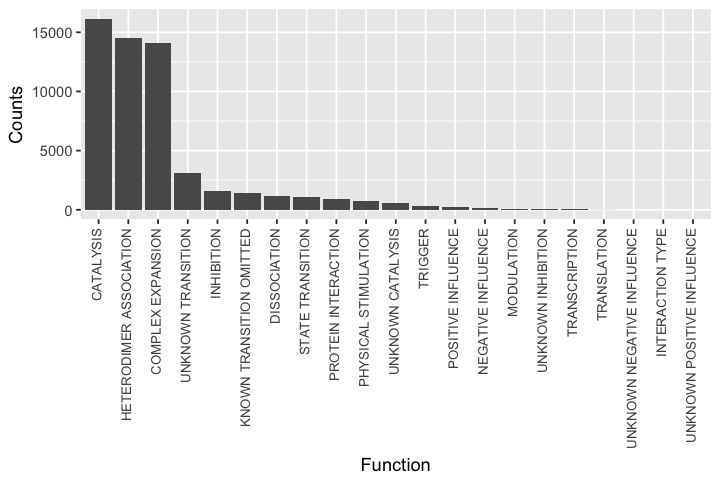

In [5]:
options(repr.plot.width=6, repr.plot.height=4)
merge(acsn, biogrid, all = TRUE) %>%
    mutate(biogrid = ifelse(is.na(biogrid), F, T),
           acsn = ifelse(is.na(acsn), F, T)) %>%
    filter(acsn & ! biogrid) %>% 
    .$type %>%
    lapply(strsplit, ";") %>% 
    unlist %>% 
    table %>% 
    as.data.frame %>%
    set_colnames(c("Function", "Counts")) %>%
    arrange(-Counts) %>%
    mutate(Function = gsub("_", " ", Function),
           Function = factor(Function, levels = unique(Function))) %>%
    ggplot(aes(x = Function, y = Counts)) + 
        geom_bar(stat = "identity") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3, size = 8))

In [6]:
filter(consensus, acsn & ! biogrid) %>% head(20)

key,acsn,type,biogrid
,TRUE,INTERACTION_TYPE,FALSE
14-3-3*-E2F1,TRUE,POSITIVE_INFLUENCE,FALSE
ABL1-CASP8,TRUE,CATALYSIS,FALSE
ABL1-CASP8,TRUE,CATALYSIS,FALSE
ABL1-CSK,TRUE,UNKNOWN_TRANSITION,FALSE
ABL1-FYN,TRUE,UNKNOWN_TRANSITION,FALSE
ABL1-RAD9B,TRUE,CATALYSIS,FALSE
ABR-ABR,TRUE,UNKNOWN_TRANSITION,FALSE
ABR-ABR,TRUE,UNKNOWN_TRANSITION,FALSE
ABR-ARHGAP1,TRUE,UNKNOWN_TRANSITION,FALSE
